<a href="https://colab.research.google.com/github/Gibbons-Lab/isb_course_2024/blob/main/16S_2024.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🦠 Amplicon Sequencing Data Analysis with QIIME 2

### 🔗 Important Links
- [Course Github](https://github.com/Gibbons-Lab/isb_course_2024): Github repository for the 2024 ISB Virtual Microbiome Series

    - [Day 1 Slides](https://gibbons-lab.github.io/isb_course_2024/16S): Presentation slides that accompany this notebook

    - [Day 1 Solutions](https://github.com/Gibbons-Lab/isb_course_2024/16S_solutions.ipynb): Pre-run notebook 

    - [Treasure chest](https://github.com/Gibbons-Lab/isb_course_2024/tree/main/treasure_chest): All files generated in the notebooks
    
- [QIIME 2 view](http://view.qiime2.org): A browser-based interface for viewing QIIME artifacts and visualizations (tables and plots)
- [QIIME 2 plugins](https://docs.qiime2.org/2024.5/plugins/): more information on the QIIME 2 plugins we're using today

### 🛑 STOP! Before you run anything ...

1. Save your own local copy of this notebook by using `File > Save a copy in Drive`. At some point you may be prompted to trust the notebook. We promise that it is safe 🤞

2. Keep in mind, **the code in this notebook must be run IN ORDER** If you get lost or encounter errors, all outputs can be found in `materials/treasure chest` or on the link above.

**Disclaimer:** The Google Colab notebook environment will interpret any command as Python code by default. If we want to run bash commands we will have to prefix them by `!`. So any command you see with a leading `!` is a bash command and if you wanted to run it in your terminal you would omit the `!`. For example, if in the Colab notebook you ran `!wget` you would just run `wget` in your terminal.

---
# Setup

QIIME 2 is usually installed by following the [official installation instructions](https://docs.qiime2.org/2024.5/install/). However, because we are using Google Colab and there are some caveats to using conda here, we will have to hack around the installation a little bit. But no worries, we provide a setup script below which does all this work for us. 😌

So...let's start by pulling a local copy of the project repository down from GitHub. This repository, called `materials`, contains all the relevant data and other resources we'll need for this course. 

In [ ]:
!git clone https://github.com/gibbons-lab/isb_course_2024 materials

To view the directory, you can click on the folder 📁 icon on the left. To run code from this directory, we will navigate to it via command line:

In [ ]:
%cd materials

Notice here we use ```%``` instead of ```!``` to run our command line function. This makes the path change to our directory _permanent_. Using the ```!``` operator only switches the interpreter to expect command line prompts temporarily.




Now that we have all our materials, we're _almost_ ready to get started - but not quite. Remember QIIME? We'll need to install that before getting into the actual analysis. Don't worry - this will only set up in the Colab notebook, not on your local machine.

**Let's run the following cell, to install and setup QIIME2**

In [ ]:
%run setup_qiime2

⬆️ This will take some time (usually 10 to 15 minutes), so we'll switch back over to the [presentation](https://gibbons-lab.github.io/isb_course_2024/16S) while we wait.

If you want to learn more about QIIME2, we recommend you check out the [documentation](https://docs.qiime2.org/). This will also explain how to install QIIME2 on your local machine 🖥

---
# Data Import

QIIME2 can take us from raw sequences to ecological insight!
![our workflow](https://github.com/Gibbons-Lab/isb_course_2024/raw/main/docs/16S/assets/steps.png)
But we first need to get our raw data into QIIME2. To do this, we will need:
1. **Raw sequencing files** (.fastq): FASTQ files contain both sequence and quality scores, as opposed to FASTA, which only have sequence. We want those quality scores so that we can trim or discard low-quality reads.

2. **Metadata file** (.tsv): This file contains the sample id, along with all non-sequencing data for each sample. Here, our metadata includes disease status, age, sex, BMI, geographical location, and prescription drug use, as well as some information on diet and GI symptoms.

3. **Manifest file** (.tsv): This file contains the sample id and the path to its sequencing file. This is how QIIME matches a sequence to its correct metadata. 📝

Let's begin by taking a look at our data. In the `data` folder, you'll find 10 FASTQ files, a file manifest, and a metadata file.

If we read in `manifest.tsv`, we can see that it is a table containing the _name_ and _filepath_ of all our samples.

In [1]:
import pandas as pd
manifest = pd.read_csv('data/manifest.tsv', sep = '\t')
manifest

,sample-id,absolute-filepath
0,ERR1513701,$PWD/data/ERR1513701.fastq.gz
1,ERR1513870,$PWD/data/ERR1513870.fastq.gz
2,ERR1513889,$PWD/data/ERR1513889.fastq.gz
3,ERR1513684,$PWD/data/ERR1513684.fastq.gz
4,ERR1513703,$PWD/data/ERR1513703.fastq.gz
5,ERR1514003,$PWD/data/ERR1514003.fastq.gz
6,ERR1513961,$PWD/data/ERR1513961.fastq.gz
7,ERR1513983,$PWD/data/ERR1513983.fastq.gz
8,ERR1513964,$PWD/data/ERR1513964.fastq.gz
9,ERR1513777,$PWD/data/ERR1513777.fastq.gz


We can also check out `metadata.tsv`, which will give us more context on our samples 🔬

In [2]:
metadata = pd.read_csv('data/metadata.tsv', sep='\t')
metadata

,id,parkinson_disease,sex,age,bmi,stool_travel_time,location,anticholinergic,carbidopa_levodopa,comt_inhibitor,p3m_antibiotics_bool,p3m_constipation,fruits_or_vegetables,grains
0,ERR1513684,Yes,male,58.0,25.33,6.0,"Atlanta, GA",N,Y,N,Yes,Yes,At least once a day,At least once a day
1,ERR1513701,Yes,male,78.0,18.99,2.0,"Atlanta, GA",N,Y,N,No,No,Few times a week,At least once a day
2,ERR1513703,Yes,female,53.0,27.92,4.0,"Atlanta, GA",N,Y,N,Yes,No,At least once a day,At least once a day
3,ERR1513777,No,female,62.0,22.96,1.0,"Albany, NY",N,N,N,No,No,At least once a day,At least once a day
4,ERR1513870,Yes,male,70.0,25.68,8.0,"Seattle, WA",N,Y,N,Yes,Yes,Few times a week,At least once a day
5,ERR1513889,Yes,male,78.0,30.51,3.0,"Seattle, WA",N,Y,N,No,No,At least once a day,Few times a week
6,ERR1513961,No,female,67.0,24.48,2.0,"Seattle, WA",N,N,N,Yes,No,At least once a day,At least once a day
7,ERR1513964,No,female,69.0,33.47,4.0,"Seattle, WA",N,N,N,No,No,At least once a day,Few times a week
8,ERR1513983,No,female,72.0,25.84,2.0,"Seattle, WA",N,N,N,No,No,At least once a day,At least once a day
9,ERR1514003,No,male,63.0,31.29,3.0,"Seattle, WA",N,N,N,No,No,At least once a day,At least once a day


Looks good, all 10 FASTQ files are accounted for, five healthy and five with Parkinson's Disease. We can use the manifest file to import our files into QIIME.

## FASTQ to Artifact

To use sequencing data in QIIME, we first need to turn the FASTQ files containing our data into QIIME artifacts. Using the manifest we just checked out, let's run our first command:

-- as a reminder, adding ```!``` before the command tells the notebook this is a **bash** command, rather than python.

In [ ]:
!qiime tools import \
  --type 'SampleData[SequencesWithQuality]' \
  --input-path data/manifest.tsv \
  --output-path sequences.qza \
  --input-format SingleEndFastqManifestPhred33V2

Let's take a look a the command. QIIME commands take following format:

```
qiime plugin action --i-argument1 ... --o-argument2 ...
```
In the previous command, we are calling the ```tools``` plugin within QIIME2 to import our data. The following arguments designate where the manifest is, as well as where the output should be saved. We also tell QIIME what sort of input to expect.

Argument types usually begin with a letter denoting their meaning:

- `--i-...` = input files
- `--o-...` = output files
- `--p-...` = parameters
- `--m-...` = metadata

## Artifact to Visualization 🔎

Before we move on, let's use QIIME to visualize our sequencing data.

In [ ]:
!qiime demux summarize \
--i-data sequences.qza \
--o-visualization qualities.qzv

.qzv files like the one we just produced are visualization. You can view the plot by **downloading the file and opening it using http://view.qiime2.org**. To download the file click on the folder symbol to the left, open the `materials` folder, and choose download from the dot menu next to the `qualities.qzv` file.

---
# Quality Filtering: From Sequence to ASV


Before we can use our sequencing data, we need to "denoise" it. To do this, we'll use a *plugin* called ```DADA2```. This involves a few things:

1. filter and trim the reads
2. find the most likely set of unique sequences in the sample (ASVs)
3. remove chimeras
4. count the abundances of each ASV


This command will take a little time - let's run it, and head back to the presentation to discuss what's happening.

In [ ]:
!qiime dada2 denoise-single \
    --i-demultiplexed-seqs sequences.qza \
    --p-trunc-len 150 \
    --p-n-threads 2 \
    --output-dir dada --verbose


If this step takes too long or fails, you can also copy the results from the treasure chest with the following command.

In [ ]:
# obscure magic that will only copy if the previous command failed
![ -d dada ] || cp -r treasure_chest/dada .

If we open up the `dada` folder 📁, we will see several outputs.
- `representative_sequences.qza` is our *ASV abundance table* 🧬
- `denoising-stats.qza` contains the *denoising statistics* 📊

We'll want to look at the denoising statistics to make sure the denoising went well. It is normal to lose between 5-25% of reads to chimeras, but major loss could be due to running too many PCR cycles.

As mentioned before, we can't view QIIME *artifacts* directly, but we can convert them to *visualizations* using the action `tabulate` from the plugin `metadata`.

In [ ]:
!qiime metadata tabulate \
    --m-input-file dada/denoising_stats.qza \
    --o-visualization dada/denoising-stats.qzv

Like before, we can download the .qzv file and visualize the results using the [QIIME2 Viewer](https://view.qiime2.org/).

It's important to understand what this output tells us. For instance, what percent of reads in our data pass the filtering step? What percent of reads were non-chimeric? Differences in these metrics between samples can affect diversity metrics.

For more information on paired-end quality filtering, check out the [2023 course](https://github.com/Gibbons-Lab/isb_course_2023)! 

---
# Phylogenetics

Now that we have an ASV table, we can calculate diversity metrics! But first, head back to the [presentation](https://gibbons-lab.github.io/isb_course_2024/16S) for an introduction to diversity!

Note: we're getting into analyses that some may prefer to perform in RStudio or Jupyter Notebooks, without the use of the QIIME framework. For example, diversity analyses can be performed using `scikit-bio` in Python or `vegan` in R. In fact, QIIME2 is using `scikit-bio` and `vegan` under the hood for its diversity calculations!

### From ASVs to Phylogenetic Trees with QIIME2 `phylogeny`

Some *diversity metrics* are calculated using **phylogenetic distance**, so let's start by building a phylogenetic tree for our sequences using the following command. This time, we call the `phylogeny` plugin in QIIME2.

In [ ]:
!qiime phylogeny align-to-tree-mafft-fasttree \
    --i-sequences dada/representative_sequences.qza \
    --output-dir tree

We can create a visualization for the tree using the `empress` QIIME 2 plugin. See [documentation](https://github.com/biocore/empress) for more details.

In [ ]:
!qiime empress tree-plot \
    --i-tree tree/rooted_tree.qza \
    --o-visualization tree/empress.qzv

---
# Diversity

## Part 1: The Basics

The QIIME2 `diversity` plugin has an action called `core-metrics-phylogenetic`, which calculates _several_ phylogenetic and non-phylogenetic diversity metrics.

We can use our table and tree to calculate several diversity metrics. To account for variations in **sampling depth**, we'll provide QIIME2 with a cutoff at which we will **rarefy** all our samples. Rarefaction  **randomly** selects sequences, so your results might look a little different from mine. We'll also pass in our metadata file, so we can keep track of which samples come from each group.

In [ ]:
!qiime diversity core-metrics-phylogenetic \
    --i-table dada/table.qza \
    --i-phylogeny tree/rooted_tree.qza \
    --p-sampling-depth 5000 \
    --m-metadata-file data/metadata.tsv \
    --output-dir diversity

If you open the `diversity` folder, you'll see that we calculated all of the diversity metrics I just mentioned. For more information on how these diversity metrics are calculated and interpreted, check out this QIIME [forum post](https://forum.qiime2.org/t/alpha-and-beta-diversity-explanations-and-commands/2282).

But what we're really interested in is whether diversity differs *significantly* between disease and healthy samples, or other covariates. Therefore, we will need to do statistical tests. 

Head back to the [slides](https://gibbons-lab.github.io/isb_course_2024/16S), and we'll go over some types of statistical tests, and when to use them.

### Alpha diversity: richness and evenness _within_ a sample

We get a bunch of outputs from the previous command - measures of both alpha and beta diversity. To start, let's use the Shannon vector in the output directory to create a visualization of alpha diversity across samples. Generally, healthy, long-living individuals have balanced diverse microbiomes. However, this isn't necessarily a direct indicator of health or disease. Let's see how it looks in our samples

In [ ]:
!qiime diversity alpha-group-significance \
    --i-alpha-diversity diversity/shannon_vector.qza \
    --m-metadata-file data/metadata.tsv \
    --o-visualization diversity/alpha_groups.qzv

Like before, we can download the visualization and open it with the [QIIME2 viewer](http://view.qiime2.org).

### Beta diversity: distance between samples

Let's visualize the beta diversity and see how they separate. For this we'll look at weighted UniFrac. This time, we'll have to download the file ⬅️

We can check for 'significant' separation between samples using PERMANOVA. We can do this with the diversity plugin in QIIME2.

In [ ]:
!qiime diversity adonis \
    --i-distance-matrix diversity/weighted_unifrac_distance_matrix.qza \
    --m-metadata-file data/metadata.tsv \
    --p-formula "parkinson_disease" \
    --p-n-jobs 2 \
    --o-visualization diversity/permanova.qzv

We already ran a PCoAs for each distance metric, and we can look at them if we open `weighted_unifrac_emperor.qzv`, `unweighted_unifrac_emperor.qzv`, `bray_curtis_emperor.qzv`, or `jaccard_emperor.qzv` in [QIIME2 viewer](http://view.qiime2.org).

### Are these results informative? A discussion of sample size, effect size, and confounding

These results aren't very informative, and in some cases they are counterintuitive. There are several reasons this may be:

1. **Small sample size:** We are using a very small sample size (n = 10). Even if we could observe trends, we wouldn't expect statistical significance.

2. **Shannon diversity is a very coarse-grain metric:** Shannon Index attempts to summarize microbiome diversity (very complicated) into a single number.

3. **Strong confounders:** This data is from an observational study, were confounders were not controlled. Some confounders (like diet and drug exposure) are known to have strong effects on diversity, which may conceal smaller relationships between the microme and a variable of interest (like disease status).

In observational studies, it is common to **stratify** across confounders, or include them as **covariates** in regressions. It is recommended to have **at least 10 samples for every variable** in a multivariate regression like PERMANOVA, general linear model (GLM) or ___. So with a sample size n = 10, we can really only test 1 variable without breaking assumptions. 

**But what if we had a bigger sample size?** This would open the door to more types of analyses. We couldn't process the entire dataset on Colab due to limited computational power, but luckily, **we've pre-processed the entire dataset for you**!

## Part 2: Dealing with confounders

### Alpha Diversity Stratification

The full Hill-Burns 2017 dataset files are in the MATERIALS FOLDER. Let's load them into QIIME2 now.

We'll keep this analysis in the `complete_study` folder so we don't confuse our files from earlier.

If you get lost at any point, the outputs generated from the complete dataset can be found in `treasure_chest/complete_study_outputs`

In [ ]:
# Copy full dataset directory into your local directory
![ -d complete_study ] || cp -r treasure_chest/complete_study .

We now have a LOT more metadata than before. Let's take a peek.

In [6]:
complete_metadata = pd.read_csv('complete_study/complete_metadata.tsv', sep='\t')
print(complete_metadata.shape)
complete_metadata.head()

(330, 39)


,id,parkinson_disease,sex,age,bmi,location,anticholinergic,antibiotics_bool,anti_inflammatory_bool,comt_inhibitor,...,crohns_disease,yogurt_live_culture,nuts,grains,fruits_or_vegetables,meats,tobacco,marijuana,alcohol_bool,coffee_bool
0,ERR1513669,No,female,79.0,28.34,"Atlanta, GA",N,No,Yes,N,...,No,NaN,Few times a week,Few times a week,Few times a week,Few times a week,False,False,True,True
1,ERR1513670,No,female,70.0,33.12,"Atlanta, GA",N,No,Yes,N,...,No,NaN,Few times a month,At least once a day,At least once a day,At least once a day,False,False,False,True
2,ERR1513671,No,female,79.0,32.28,"Atlanta, GA",N,No,No,N,...,No,Yes,At least once a day,At least once a day,At least once a day,At least once a day,False,False,False,False
3,ERR1513672,No,female,70.0,24.44,"Atlanta, GA",N,No,No,N,...,No,No,Few times a week,At least once a day,Few times a week,At least once a day,False,False,True,False
4,ERR1513673,No,male,76.0,25.06,"Atlanta, GA",N,No,Yes,N,...,No,NaN,At least once a day,Few times a week,At least once a day,Few times a week,False,False,True,True


In the original paper, the authors found that anticholinergic medications, catechol-O-methyltransferase (comt) inhibitors, region, sex, age, and PD had significant, independent signals on microbiome composition. How does alpha diversity vary across these variables?

In [ ]:
!qiime diversity alpha-group-significance \
    --i-alpha-diversity complete_study/diversity/shannon_vector.qza \
    --m-metadata-file complete_study/complete_metadata.tsv \
    --o-visualization complete_study/diversity/alpha_groups.qzv

Once again, view in [QIIME2 viewer](http://view.qiime2.org).

Notice that `alpha-group-significance` performs a _separate_ Kruskal-Wallis test for each variable, and outputs an _un-adjusted p-value_. If we want to analyze _multiple_ alpha diversity-covariate relationships (i.e. perform multiple tests), then we need to _control the fales discovery rate (FDR) by correcting our p-values_. We will go over this later.

What happens if we want to test for differences in alpha diversity between PD and HC, but isolated from a possible confounder: sex? We can __stratify__ our data by sex and perform diversity analyses within different groups.

QIIME has filtering functions within its different plugins. To filter the alpha diversity table based on a metadata value, we will run `filter-alpha-diversity`

In [ ]:
!qiime diversity filter-alpha-diversity \
    --i-alpha-diversity complete_study/diversity/shannon_vector.qza \
    --m-metadata-file complete_study/complete_metadata.tsv \
    --p-where "[sex] = 'female'" \
    --o-filtered-alpha-diversity complete_study/diversity/shannon_vector_female.qza

!qiime diversity filter-alpha-diversity \
    --i-alpha-diversity complete_study/diversity/shannon_vector.qza \
    --m-metadata-file complete_study/complete_metadata.tsv \
    --p-where "[sex] = 'male'" \
    --o-filtered-alpha-diversity complete_study/diversity/shannon_vector_male.qza

We run significance testing and make a visualization the same way we did before, with `alpha-group-significance`

In [ ]:
!qiime diversity alpha-group-significance \
    --i-alpha-diversity complete_study/diversity/shannon_vector_female.qza \
    --m-metadata-file complete_study/complete_metadata.tsv \
    --o-visualization complete_study/diversity/alpha_groups_female.qzv

!qiime diversity alpha-group-significance \
    --i-alpha-diversity complete_study/diversity/shannon_vector_male.qza \
    --m-metadata-file complete_study/complete_metadata.tsv \
    --o-visualization complete_study/diversity/alpha_groups_male.qzv

Take a look: [QIIME2 viewer](http://view.qiime2.org).

### PCoA + PERMANOVA for Beta diversity

Since we now have n = 300+, we can include more variables in our PERMANOVA.

First, let's run ANOVA for just disease status so we can really see what adding covariates does to our results

In [ ]:
!qiime diversity adonis \
    --i-distance-matrix complete_study/diversity/weighted_unifrac_distance_matrix.qza \
    --m-metadata-file complete_study/complete_metadata.tsv \
    --p-formula "parkinson_disease" \
    --p-n-jobs 2 \
    --o-visualization complete_study/diversity/permanova_PD.qzv

If you look at the table in [QIIME2 viewer](http://view.qiime2.org), you'll notice that since our sample size increased, the effect of PD on UniFrac beta diversity (though very small at R-squared = 0.01) is now significant (at least before FDR corrections).

We can also use PERMANOVA to identify confounders. PERMANOVA tells us how much variance in the community composition is explained by each variable. Common confounders include sex, age, BMI, diet, and antibiotic use. In the original study, authors identified that Parkinson's Disease medications were associated with different microbiome compositions. Let's take a look at these variables.

But wait - `adonis` requires any variables in the formula to have no NaN/missing values! If we tried to run `adonis` with all of these variables, it would throw an error. So we will have to **filter** out samples that have NA values for any variables we want to test. 

Let's look at the metadata file to see which variables have NaN values.

In [17]:
metadata_perm = complete_metadata[['parkinson_disease', 'sex', 'age', 'bmi', 'comt_inhibitor', 'carbidopa_levodopa', 'anticholinergic', 'location']].copy()
metadata_perm

,parkinson_disease,sex,age,bmi,comt_inhibitor,carbidopa_levodopa,anticholinergic,location
0,No,female,79.0,28.34,N,N,N,"Atlanta, GA"
1,No,female,70.0,33.12,N,N,N,"Atlanta, GA"
2,No,female,79.0,32.28,N,N,N,"Atlanta, GA"
3,No,female,70.0,24.44,N,N,N,"Atlanta, GA"
4,No,male,76.0,25.06,N,N,N,"Atlanta, GA"
...,...,...,...,...,...,...,...,...
325,No,male,74.0,30.81,N,N,N,"Seattle, WA"
326,No,female,66.0,41.96,N,N,N,"Seattle, WA"
327,No,female,74.0,34.44,N,N,N,"Seattle, WA"
328,No,female,63.0,27.48,N,N,N,"Seattle, WA"


In [15]:
# what variables have N/A values for the PERMANOVA we want to run?
col_na_num = metadata_perm.isna().sum()
col_na_bool = col_na_num[col_na_num > 0]
col_na_bool

bmi                   11
comt_inhibitor        13
carbidopa_levodopa    13
anticholinergic       13
dtype: int64

Looks like a subset of people did not fill out these questions. How many samples will we have if we filter them out?

In [16]:
metadata_perm.dropna(axis=0, subset=['bmi', 'comt_inhibitor', 'carbidopa_levodopa', 'anticholinergic'], how='any')

,parkinson_disease,sex,age,bmi,comt_inhibitor,carbidopa_levodopa,anticholinergic,location,age
0,No,female,79.0,28.34,N,N,N,"Atlanta, GA",79.0
1,No,female,70.0,33.12,N,N,N,"Atlanta, GA",70.0
2,No,female,79.0,32.28,N,N,N,"Atlanta, GA",79.0
3,No,female,70.0,24.44,N,N,N,"Atlanta, GA",70.0
4,No,male,76.0,25.06,N,N,N,"Atlanta, GA",76.0
...,...,...,...,...,...,...,...,...,...
325,No,male,74.0,30.81,N,N,N,"Seattle, WA",74.0
326,No,female,66.0,41.96,N,N,N,"Seattle, WA",66.0
327,No,female,74.0,34.44,N,N,N,"Seattle, WA",74.0
328,No,female,63.0,27.48,N,N,N,"Seattle, WA",63.0


We can use the QIIME plugin `filter-distance-matrix` this time

In [ ]:
# filter QIIME table
!qiime diversity filter-distance-matrix \
    --i-distance-matrix complete_study/diversity/weighted_unifrac_distance_matrix.qza \
    --m-metadata-file complete_study/complete_metadata.tsv \
    --p-where "[bmi] IS NOT NULL AND [comt_inhibitor] IS NOT NULL AND [carbidopa_levodopa] IS NOT NULL AND [anticholinergic] IS NOT NULL" \
    --o-filtered-distance-matrix complete_study/diversity/weighted_unifrac_distance_matrix_no_NA.qza

In [ ]:
!qiime diversity adonis \
    --i-distance-matrix complete_study/diversity/weighted_unifrac_distance_matrix_no_NA.qza \
    --m-metadata-file complete_study/complete_metadata.tsv \
    --p-formula "parkinson_disease + sex + age + bmi + location + comt_inhibitor + carbidopa_levodopa + anticholinergic" \
    --p-n-jobs 2 \
    --o-visualization complete_study/diversity/permanova_with_confounders.qzv

Before, we did not see a significant p-value for the effect of Parkinson's disease on beta diversity. However, when we add certain covariates, we might find that they were confounding a relationship. 

However, most of our variance remains unexplained. Microbiome composition is affected by many things, and this is an uncontrolled cohort study, so we would not expect any single variable to explain most of the variance.

#### Dimensionality reduction

If we want to __visually__ show this separation between samples, we can't just plot the entire UniFrac distance matrix, because it has 100+ dimensions! Instead, we can use **dimensionality reduction** to "compress" our data into a few dimensions that explain most of the variance. There are several types of dimensionality reduction (like UMAP and tSNE), but the preferred method of dimensionality reduction for microbiome communities is Principal Coordinate Analysis (PCoA). This is because PCoA is linear, and thus preserves the global structure of the data and is reproducible.

We already ran a PCoAs for each distance metric, and we can look at them if we download `weighted_unifrac_emperor.qzv`, `unweighted_unifrac_emperor.qzv`, `bray_curtis_emperor.qzv`, or `jaccard_emperor.qzv`

---
# Taxonomic Classification

### From ASV to taxonomic count table

We can learn a lot from diversity metrics, alpha and beta. But to really dig into the data, we need to know what microbes are in each sample 🦠. To do this, we'll classify the reads in QIIME2 using a pre-trained Bayesian classifier. Several such classifiers are available at https://docs.qiime2.org/2024.5/data-resources/

From the QIIME2 plugin `feature-classifier`, we will use the action the action `classifiy-sklearn` which takes your ASVs and a pre-trained scikit-learn classifier as inputs. We are using a Naive Bayesian classifier specific to the 16S V4 region (515f-806r) because that is the region we sequence, but also it will make it easier to run MICOM tomorrow!

In [ ]:
# run a classifier on our 10-sample mini dataset
!qiime feature-classifier classify-sklearn \
    --i-reads dada/representative_sequences.qza \
    --i-classifier ncbi-refseq-genus-515f-806r.qza \
    --p-n-jobs 2 \
    --o-classification taxa.qza

Now we've classified the reads, we can visualize the taxonomic breakdown of our samples.

In [ ]:
!qiime taxa barplot \
    --i-table dada/table.qza \
    --i-taxonomy taxa.qza \
    --m-metadata-file data/metadata.tsv \
    --o-visualization taxa_barplot.qzv

Now, we can use ```table.qza```, which contains our reads, and ```taxa.qza```, which contains taxonomic classifications for reads, and collapse the data onto the genus level.

In [ ]:
!qiime taxa collapse \
    --i-table dada/table.qza \
    --i-taxonomy taxa.qza \
    --p-level 6 \
    --o-collapsed-table genus.qza

### Exporting your taxa table

Taxonomic feature tables in QIIME2 can be exported as .biom files, which can then be converted to .tsv files if desired. This is important, because some analysis methods not available on QIIME2 may require .biom or .tsv formats.

We'll export this as a .tsv, which will be more usable for the next portion of the course that you'll see tomorrow.

In [ ]:
!qiime tools export \
    --input-path genus.qza \
    --output-path exported
    
!biom convert -i exported/feature-table.biom -o genus.tsv --to-tsv

Let's peek at the results 🔭

In [24]:
abundances = pd.read_table("genus.tsv", skiprows=1, index_col=0)
abundances

,ERR1513684,ERR1513701,ERR1513703,ERR1513777,ERR1513870,ERR1513889,ERR1513961,ERR1513964,ERR1513983,ERR1514003
#OTU ID,,,,,,,,,,
k__Bacteria;p__Firmicutes;c__Clostridia;o__Eubacteriales;f__Peptococcaceae;g__Peptococcus,0.0,2.0,0.0,0.0,0.0,0.0,0.0,14.0,0.0,0.0
k__Bacteria;p__Firmicutes;c__Clostridia;o__Eubacteriales;f__Eubacteriales;g__Gemmiger,11.0,0.0,0.0,110.0,150.0,55.0,147.0,224.0,12.0,55.0
k__Bacteria;p__Firmicutes;c__Clostridia;o__Eubacteriales;__;__,39.0,21.0,44.0,1816.0,595.0,177.0,82.0,1418.0,236.0,24.0
k__Bacteria;p__Firmicutes;c__Clostridia;o__Eubacteriales;f__Oscillospiraceae;g__Ruthenibacterium,0.0,15.0,51.0,0.0,0.0,21.0,9.0,0.0,0.0,0.0
k__Bacteria;p__Firmicutes;c__Clostridia;o__Eubacteriales;f__Oscillospiraceae;g__Faecalibacterium,852.0,0.0,186.0,2485.0,4000.0,1000.0,1025.0,1113.0,344.0,698.0
...,...,...,...,...,...,...,...,...,...,...
k__Bacteria;p__Firmicutes;c__Clostridia;o__Eubacteriales;f__Lachnospiraceae;g__Butyribacter,0.0,0.0,0.0,8.0,42.0,48.0,3.0,0.0,17.0,14.0
k__Bacteria;p__Firmicutes;c__Clostridia;o__Eubacteriales;f__Lachnospiraceae;g__[Eubacterium],0.0,0.0,38.0,255.0,516.0,439.0,402.0,0.0,0.0,1569.0
k__Bacteria;p__Firmicutes;c__Clostridia;o__Eubacteriales;f__Lachnospiraceae;g__Bariatricus,13.0,0.0,0.0,0.0,193.0,0.0,0.0,0.0,0.0,10.0


This is easier to interpret by visualizing the results. We can use the file we just exported from QIIME2 to build a visualization using any tool we like, such as seaborn or plotnine.

Here is an example of building a visualization (a heatmap) in seaborn:

In [20]:
import numpy as np
import seaborn as sns

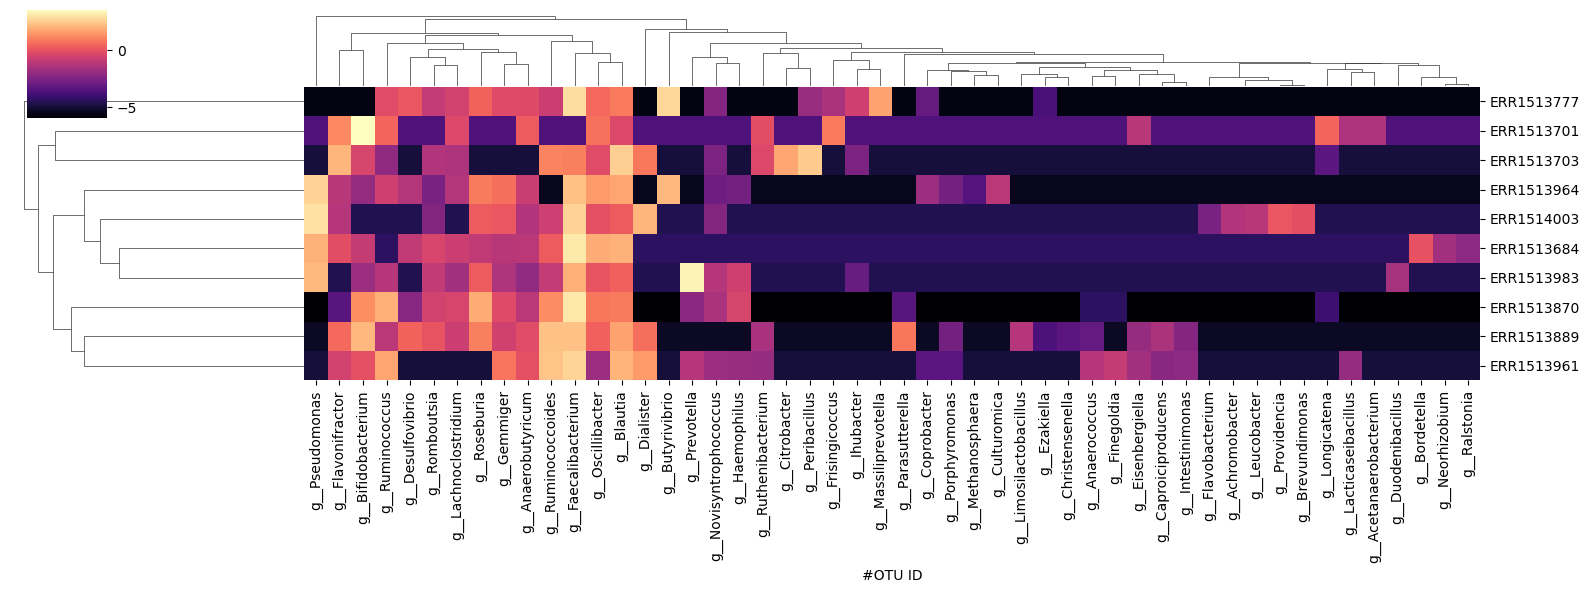

In [25]:
abund_to_plot = abundances.copy()
abund_to_plot.index = abund_to_plot.index.str.split(";").str[5]          # Use only the genus name
abund_to_plot = abund_to_plot[~abund_to_plot.index.isin(["g__", "__"])]  # remove unclassified genera
abund_to_plot = abund_to_plot.sample(50, axis=0)                         # use 50 random genera (rows)

# Let's do a centered log-ratio transform: log x_i - log mean(x)
transformed = abund_to_plot.apply(
    lambda xs: np.log(xs + 0.5) - np.log(xs.mean() + 0.5),
    axis=0)

sns.clustermap(transformed.T, cmap="magma", xticklabels=True, figsize=(16, 6))

Now, our data is starting to be interpretable. Each row is a sample, and each column is a bacterial genus. The table values are "counts", or the number of times a genus was detected in a certain sample. We can use relative abundance data to test hypotheses, but it requires special statistical methods because it is ___compositional___.

Let's discuss what we can do about that in the [presentation](https://gibbons-lab.github.io/isb_course_2024/16S).

---
# Differential Abundance Analysis

Let's look at abundances in the _complete_ dataset, so you can see the abundance distributions.

We're going to be switching to python to show you these transformations, so we'll need a few more packages 📦

In [40]:
import scipy.stats as stats
import matplotlib.pyplot as plt

### Counts to relative abundance:

Before we do any testing, we need to divide genus counts by total sample counts. This gives us _relative abundance_

In [52]:
complete_abundances = pd.read_table('complete_study/genus.tsv', skiprows=1, index_col=0)
complete_abundances

,ERR1513669,ERR1513670,ERR1513671,ERR1513672,ERR1513673,ERR1513674,ERR1513675,ERR1513676,ERR1513677,ERR1513678,...,ERR1514006,ERR1514007,ERR1514008,ERR1514009,ERR1514010,ERR1514011,ERR1514012,ERR1514013,ERR1514014,ERR1514015
#OTU ID,,,,,,,,,,,,,,,,,,,,,
k__Bacteria;__;__;__;__;__,0.0,4.0,19.0,14.0,7.0,27.0,274.0,3.0,4.0,7.0,...,30.0,27.0,3.0,3.0,21.0,23.0,0.0,13.0,21.0,2.0
k__Bacteria;p__Firmicutes;c__Clostridia;o__Eubacteriales;f__Peptococcaceae;g__Peptococcus,0.0,0.0,0.0,17.0,0.0,9.0,0.0,0.0,0.0,0.0,...,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
k__Bacteria;p__Firmicutes;c__Clostridia;o__Eubacteriales;f__Eubacteriales;g__Gemmiger,0.0,215.0,34.0,0.0,0.0,0.0,53.0,8.0,85.0,69.0,...,62.0,83.0,362.0,200.0,0.0,33.0,11.0,1412.0,52.0,8.0
k__Bacteria;p__Firmicutes;c__Clostridia;o__Eubacteriales;f__Lachnospiraceae;__,106.0,203.0,252.0,83.0,1071.0,285.0,52.0,68.0,258.0,961.0,...,650.0,281.0,469.0,337.0,157.0,39.0,118.0,316.0,54.0,18.0
k__Bacteria;p__Firmicutes;c__Clostridia;o__Eubacteriales;f__Oscillospiraceae;g__Faecalibacterium,89.0,632.0,496.0,348.0,26.0,427.0,728.0,670.0,584.0,3131.0,...,674.0,1103.0,3883.0,1302.0,672.0,296.0,1217.0,1013.0,141.0,81.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
k__Bacteria;p__Fusobacteria;c__Fusobacteriia;o__Fusobacteriales;f__Fusobacteriaceae;g__Cetobacterium,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
k__Bacteria;p__Fusobacteria;c__Fusobacteriia;o__Fusobacteriales;f__Leptotrichiaceae;g__Sneathia,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Pseudomonadales;__;__,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [53]:
rel_abund = complete_abundances.divide(complete_abundances.sum(axis=0), axis=1)     # divide all values in a row by the sum of the row
rel_abund

,ERR1513669,ERR1513670,ERR1513671,ERR1513672,ERR1513673,ERR1513674,ERR1513675,ERR1513676,ERR1513677,ERR1513678,...,ERR1514006,ERR1514007,ERR1514008,ERR1514009,ERR1514010,ERR1514011,ERR1514012,ERR1514013,ERR1514014,ERR1514015
#OTU ID,,,,,,,,,,,,,,,,,,,,,
k__Bacteria;__;__;__;__;__,0.000000,0.000235,0.001087,0.000791,0.000330,0.001991,0.034033,0.000225,0.000373,0.000341,...,0.002382,0.003130,0.000207,0.000438,0.001654,0.003234,0.000000,0.000590,0.001497,0.000243
k__Bacteria;p__Firmicutes;c__Clostridia;o__Eubacteriales;f__Peptococcaceae;g__Peptococcus,0.000000,0.000000,0.000000,0.000960,0.000000,0.000664,0.000000,0.000000,0.000000,0.000000,...,0.000318,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
k__Bacteria;p__Firmicutes;c__Clostridia;o__Eubacteriales;f__Eubacteriales;g__Gemmiger,0.000000,0.012613,0.001945,0.000000,0.000000,0.000000,0.006583,0.000601,0.007934,0.003360,...,0.004923,0.009621,0.025002,0.029193,0.000000,0.004641,0.001376,0.064054,0.003706,0.000974
k__Bacteria;p__Firmicutes;c__Clostridia;o__Eubacteriales;f__Lachnospiraceae;__,0.010902,0.011909,0.014416,0.004688,0.050469,0.021012,0.006459,0.005105,0.024081,0.046803,...,0.051608,0.032572,0.032392,0.049190,0.012367,0.005484,0.014763,0.014335,0.003849,0.002191
k__Bacteria;p__Firmicutes;c__Clostridia;o__Eubacteriales;f__Oscillospiraceae;g__Faecalibacterium,0.009154,0.037076,0.028374,0.019654,0.001225,0.031480,0.090424,0.050304,0.054508,0.152486,...,0.053513,0.127854,0.268182,0.190045,0.052934,0.041626,0.152258,0.045954,0.010049,0.009858
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
k__Bacteria;p__Fusobacteria;c__Fusobacteriia;o__Fusobacteriales;f__Fusobacteriaceae;g__Cetobacterium,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
k__Bacteria;p__Fusobacteria;c__Fusobacteriia;o__Fusobacteriales;f__Leptotrichiaceae;g__Sneathia,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Pseudomonadales;__;__,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


### Preprocessing:

Do any rows have entirely zero? 

In [54]:
rows_with_zeros = rel_abund.eq(0).all(axis=1)
count_row_zeros = rows_with_zeros.sum()
count_row_zeros

0

How many rows (genera) are not present in most samples (zero in >80% of samples?)

In [55]:
# identify sparse rows
num_zeros_row = rel_abund.eq(0).sum(axis=1)
num_cols = rel_abund.shape[1]
sparse_rows = num_zeros_row > (0.8 * num_cols)
print(sparse_rows.sum())

# remove sparse rows 
abund_filt = rel_abund[~sparse_rows]

# transpose to make samples rows rather than genera (match formatting of our metadata)
abund_filt = abund_filt.T
abund_filt

397


#OTU ID,k__Bacteria;__;__;__;__;__,k__Bacteria;p__Firmicutes;c__Clostridia;o__Eubacteriales;f__Eubacteriales;g__Gemmiger,k__Bacteria;p__Firmicutes;c__Clostridia;o__Eubacteriales;f__Lachnospiraceae;__,k__Bacteria;p__Firmicutes;c__Clostridia;o__Eubacteriales;f__Oscillospiraceae;g__Faecalibacterium,k__Bacteria;p__Firmicutes;c__Clostridia;o__Eubacteriales;__;__,k__Bacteria;p__Bacteroidetes;__;__;__;__,k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Enterobacteriaceae;__,k__Bacteria;p__Firmicutes;c__Clostridia;o__Eubacteriales;f__Lachnospiraceae;g__Blautia,k__Bacteria;p__Firmicutes;c__Clostridia;o__Eubacteriales;f__Lachnospiraceae;g__Dorea,k__Bacteria;p__Actinobacteria;c__Actinomycetia;o__Bifidobacteriales;f__Bifidobacteriaceae;g__Bifidobacterium,...,k__Bacteria;p__Firmicutes;c__Clostridia;o__Eubacteriales;f__Eubacteriales Family XIII. Incertae Sedis;g__Ihubacter,k__Bacteria;p__Proteobacteria;c__Deltaproteobacteria;o__Desulfovibrionales;f__Desulfovibrionaceae;g__Desulfovibrio,k__Bacteria;p__Proteobacteria;c__Epsilonproteobacteria;o__Campylobacterales;f__Campylobacteraceae;g__Campylobacter,k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Pasteurellales;f__Pasteurellaceae;g__Haemophilus,k__Bacteria;p__Firmicutes;c__Clostridia;o__Thermoanaerobacterales;f__Thermoanaerobacterales Family III. Incertae Sedis;g__Thermoanaerobacterium,k__Bacteria;p__Firmicutes;c__Erysipelotrichia;o__Erysipelotrichales;f__Erysipelotrichaceae;g__Longicatena,k__Bacteria;p__Firmicutes;c__Negativicutes;o__Veillonellales;f__Veillonellaceae;g__Veillonella,k__Bacteria;p__Firmicutes;c__Clostridia;o__Eubacteriales;f__Eubacteriales Family XIII. Incertae Sedis;g__Emergencia,k__Bacteria;p__Firmicutes;c__Clostridia;o__Eubacteriales;f__Lachnospiraceae;g__Tyzzerella,k__Bacteria;p__Firmicutes;c__Negativicutes;o__Acidaminococcales;f__Acidaminococcaceae;g__Acidaminococcus
ERR1513669,0.000000,0.000000,0.010902,0.009154,0.000926,0.0,0.352875,0.010593,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.012650,0.000411,0.0,0.002263,0.000000,0.000000
ERR1513670,0.000235,0.012613,0.011909,0.037076,0.071982,0.0,0.013669,0.026516,0.000880,0.004165,...,0.000645,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.050334
ERR1513671,0.001087,0.001945,0.014416,0.028374,0.005892,0.0,0.514673,0.013329,0.001316,0.007322,...,0.000172,0.0,0.000000,0.000000,0.000801,0.000286,0.0,0.000000,0.000000,0.000000
ERR1513672,0.000791,0.000000,0.004688,0.019654,0.029143,0.0,0.287699,0.020502,0.000000,0.011917,...,0.000169,0.0,0.000282,0.000000,0.084717,0.000226,0.0,0.000452,0.000000,0.000000
ERR1513673,0.000330,0.000000,0.050469,0.001225,0.014373,0.0,0.443900,0.055040,0.000000,0.004382,...,0.000000,0.0,0.000000,0.000000,0.006362,0.000000,0.0,0.000000,0.004948,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ERR1514011,0.003234,0.004641,0.005484,0.041626,0.026157,0.0,0.452679,0.007594,0.000000,0.001266,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
ERR1514012,0.000000,0.001376,0.014763,0.152258,0.025773,0.0,0.028025,0.049418,0.007381,0.000000,...,0.000000,0.0,0.000000,0.000626,0.000375,0.000000,0.0,0.000375,0.000000,0.000000
ERR1514013,0.000590,0.064054,0.014335,0.045954,0.027082,0.0,0.262021,0.008302,0.001406,0.000953,...,0.000272,0.0,0.000091,0.000000,0.000000,0.000363,0.0,0.000000,0.000000,0.000000
ERR1514014,0.001497,0.003706,0.003849,0.010049,0.007056,0.0,0.270401,0.015965,0.005630,0.001710,...,0.000000,0.0,0.000000,0.000000,0.000356,0.000000,0.0,0.000428,0.010548,0.000000


Save the column names of genera in a list, then merge the abundance and metadata tables.

In [57]:
genus_columns = abund_filt.columns                                                            # get a list of abundance column names
complete_metadata.set_index('id', inplace=True)                                               # change the index (row names) of metadata to the column 'id'
merged_rel_abund = complete_metadata.merge(abund_filt, left_index=True, right_index=True)     # merge the two dataframes by their index (row names)

,parkinson_disease,sex,age,bmi,location,anticholinergic,antibiotics_bool,anti_inflammatory_bool,comt_inhibitor,carbidopa_levodopa,...,k__Bacteria;p__Firmicutes;c__Clostridia;o__Eubacteriales;f__Eubacteriales Family XIII. Incertae Sedis;g__Ihubacter,k__Bacteria;p__Proteobacteria;c__Deltaproteobacteria;o__Desulfovibrionales;f__Desulfovibrionaceae;g__Desulfovibrio,k__Bacteria;p__Proteobacteria;c__Epsilonproteobacteria;o__Campylobacterales;f__Campylobacteraceae;g__Campylobacter,k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Pasteurellales;f__Pasteurellaceae;g__Haemophilus,k__Bacteria;p__Firmicutes;c__Clostridia;o__Thermoanaerobacterales;f__Thermoanaerobacterales Family III. Incertae Sedis;g__Thermoanaerobacterium,k__Bacteria;p__Firmicutes;c__Erysipelotrichia;o__Erysipelotrichales;f__Erysipelotrichaceae;g__Longicatena,k__Bacteria;p__Firmicutes;c__Negativicutes;o__Veillonellales;f__Veillonellaceae;g__Veillonella,k__Bacteria;p__Firmicutes;c__Clostridia;o__Eubacteriales;f__Eubacteriales Family XIII. Incertae Sedis;g__Emergencia,k__Bacteria;p__Firmicutes;c__Clostridia;o__Eubacteriales;f__Lachnospiraceae;g__Tyzzerella,k__Bacteria;p__Firmicutes;c__Negativicutes;o__Acidaminococcales;f__Acidaminococcaceae;g__Acidaminococcus
id,,,,,,,,,,,,,,,,,,,,,
ERR1513669,No,female,79.0,28.34,"Atlanta, GA",N,No,Yes,N,N,...,0.000000,0.0,0.000000,0.000000,0.012650,0.000411,0.0,0.002263,0.000000,0.000000
ERR1513670,No,female,70.0,33.12,"Atlanta, GA",N,No,Yes,N,N,...,0.000645,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.050334
ERR1513671,No,female,79.0,32.28,"Atlanta, GA",N,No,No,N,N,...,0.000172,0.0,0.000000,0.000000,0.000801,0.000286,0.0,0.000000,0.000000,0.000000
ERR1513672,No,female,70.0,24.44,"Atlanta, GA",N,No,No,N,N,...,0.000169,0.0,0.000282,0.000000,0.084717,0.000226,0.0,0.000452,0.000000,0.000000
ERR1513673,No,male,76.0,25.06,"Atlanta, GA",N,No,Yes,N,N,...,0.000000,0.0,0.000000,0.000000,0.006362,0.000000,0.0,0.000000,0.004948,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ERR1514011,No,male,74.0,30.81,"Seattle, WA",N,No,No,N,N,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
ERR1514012,No,female,66.0,41.96,"Seattle, WA",N,No,Yes,N,N,...,0.000000,0.0,0.000000,0.000626,0.000375,0.000000,0.0,0.000375,0.000000,0.000000
ERR1514013,No,female,74.0,34.44,"Seattle, WA",N,No,Yes,N,N,...,0.000272,0.0,0.000091,0.000000,0.000000,0.000363,0.0,0.000000,0.000000,0.000000


In [ ]:
# plot what we will be testing (difference in mean) for Roseburia
sns.displot(merged, x='k__Bacteria;p__Firmicutes;c__Clostridia;o__Eubacteriales;f__Peptostreptococcaceae;g__Romboutsia', hue='parkinson_disease')
plt.xlabel('Romboutsia relative abundance')
plt.ylabel('Number of samples')
# plt.savefig('RA_split_dist.png', dpi=300, transparent=True)
plt.show()

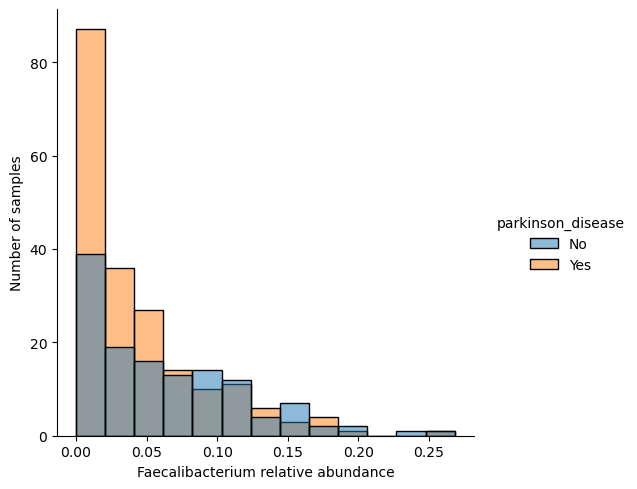

In [58]:
# Make a histogram of Faecalibacterium split by PD status

sns.displot(data=merged_rel_abund,
            x='k__Bacteria;p__Firmicutes;c__Clostridia;o__Eubacteriales;f__Oscillospiraceae;g__Faecalibacterium',
            hue='parkinson_disease')

plt.xlabel('Faecalibacterium relative abundance')
plt.ylabel('Number of samples')
plt.show()

### 1. Nonparametric tests

If we wanted to test whether Faecalibacterium specifically was differentially abundant in PD, we could do this:

In [59]:
# split the variable of interest into 2 lists by PD status
faecali_pd = merged_rel_abund[merged_rel_abund['parkinson_disease'] == 'Yes']['k__Bacteria;p__Firmicutes;c__Clostridia;o__Eubacteriales;f__Oscillospiraceae;g__Faecalibacterium']
faecali_hc = merged_rel_abund[merged_rel_abund['parkinson_disease'] == 'No']['k__Bacteria;p__Firmicutes;c__Clostridia;o__Eubacteriales;f__Oscillospiraceae;g__Faecalibacterium']

u_stat, p_value = stats.mannwhitneyu(faecali_pd, faecali_hc, alternative='two-sided')

print(f"U-statistic: {u_stat}")
print(f"p-value: {p_value}")

U-statistic: 10217.5
p-value: 0.0010104612856028604


We would see that yes, if we only perform one test, it appears that Faecalibacterium mean relative abundance is significantly different between PD and healthy controls (with p < 0.05)

### 2. Normalization + parametric tests:

Before we can do a CLR transform, we have to add a pseudocount, because log(0) does not exist.

In [60]:
# keep track of which values are nonzero
abund_nonzero = abund_filt > 0

# add a pseudocount
abund_filt_pseudo = abund_filt + 0.0000001
abund_filt_pseudo

#OTU ID,k__Bacteria;__;__;__;__;__,k__Bacteria;p__Firmicutes;c__Clostridia;o__Eubacteriales;f__Eubacteriales;g__Gemmiger,k__Bacteria;p__Firmicutes;c__Clostridia;o__Eubacteriales;f__Lachnospiraceae;__,k__Bacteria;p__Firmicutes;c__Clostridia;o__Eubacteriales;f__Oscillospiraceae;g__Faecalibacterium,k__Bacteria;p__Firmicutes;c__Clostridia;o__Eubacteriales;__;__,k__Bacteria;p__Bacteroidetes;__;__;__;__,k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Enterobacteriaceae;__,k__Bacteria;p__Firmicutes;c__Clostridia;o__Eubacteriales;f__Lachnospiraceae;g__Blautia,k__Bacteria;p__Firmicutes;c__Clostridia;o__Eubacteriales;f__Lachnospiraceae;g__Dorea,k__Bacteria;p__Actinobacteria;c__Actinomycetia;o__Bifidobacteriales;f__Bifidobacteriaceae;g__Bifidobacterium,...,k__Bacteria;p__Firmicutes;c__Clostridia;o__Eubacteriales;f__Eubacteriales Family XIII. Incertae Sedis;g__Ihubacter,k__Bacteria;p__Proteobacteria;c__Deltaproteobacteria;o__Desulfovibrionales;f__Desulfovibrionaceae;g__Desulfovibrio,k__Bacteria;p__Proteobacteria;c__Epsilonproteobacteria;o__Campylobacterales;f__Campylobacteraceae;g__Campylobacter,k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Pasteurellales;f__Pasteurellaceae;g__Haemophilus,k__Bacteria;p__Firmicutes;c__Clostridia;o__Thermoanaerobacterales;f__Thermoanaerobacterales Family III. Incertae Sedis;g__Thermoanaerobacterium,k__Bacteria;p__Firmicutes;c__Erysipelotrichia;o__Erysipelotrichales;f__Erysipelotrichaceae;g__Longicatena,k__Bacteria;p__Firmicutes;c__Negativicutes;o__Veillonellales;f__Veillonellaceae;g__Veillonella,k__Bacteria;p__Firmicutes;c__Clostridia;o__Eubacteriales;f__Eubacteriales Family XIII. Incertae Sedis;g__Emergencia,k__Bacteria;p__Firmicutes;c__Clostridia;o__Eubacteriales;f__Lachnospiraceae;g__Tyzzerella,k__Bacteria;p__Firmicutes;c__Negativicutes;o__Acidaminococcales;f__Acidaminococcaceae;g__Acidaminococcus
ERR1513669,1.000000e-07,1.000000e-07,0.010902,0.009154,9.257402e-04,1.000000e-07,0.352875,0.010594,1.000000e-07,1.000000e-07,...,1.000000e-07,1.000000e-07,1.000000e-07,1.000000e-07,1.265052e-02,4.114957e-04,1.000000e-07,2.262776e-03,1.000000e-07,1.000000e-07
ERR1513670,2.347592e-04,1.261303e-02,0.011909,0.037076,7.198180e-02,1.000000e-07,0.013669,0.026517,8.800718e-04,4.165300e-03,...,6.454127e-04,1.000000e-07,1.000000e-07,1.000000e-07,1.000000e-07,1.000000e-07,1.000000e-07,1.000000e-07,1.000000e-07,5.033449e-02
ERR1513671,1.086994e-03,1.945069e-03,0.014416,0.028374,5.892211e-03,1.000000e-07,0.514673,0.013329,1.315814e-03,7.322336e-03,...,1.717149e-04,1.000000e-07,1.000000e-07,1.000000e-07,8.009695e-04,2.861248e-04,1.000000e-07,1.000000e-07,1.000000e-07,1.000000e-07
ERR1513672,7.907924e-04,1.000000e-07,0.004688,0.019654,2.914276e-02,1.000000e-07,0.287699,0.020502,1.000000e-07,1.191696e-02,...,1.695341e-04,1.000000e-07,2.824902e-04,1.000000e-07,8.471715e-02,2.260121e-04,1.000000e-07,4.519242e-04,1.000000e-07,1.000000e-07
ERR1513673,3.299619e-04,1.000000e-07,0.050469,0.001225,1.437266e-02,1.000000e-07,0.443900,0.055040,1.000000e-07,4.382551e-03,...,1.000000e-07,1.000000e-07,1.000000e-07,1.000000e-07,6.361723e-03,1.000000e-07,1.000000e-07,1.000000e-07,4.948029e-03,1.000000e-07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ERR1514011,3.234526e-03,4.640798e-03,0.005485,0.041626,2.615676e-02,1.000000e-07,0.452679,0.007594,1.000000e-07,1.265745e-03,...,1.000000e-07,1.000000e-07,1.000000e-07,1.000000e-07,1.000000e-07,1.000000e-07,1.000000e-07,1.000000e-07,1.000000e-07,1.000000e-07
ERR1514012,1.000000e-07,1.376304e-03,0.014763,0.152258,2.577265e-02,1.000000e-07,0.028025,0.049418,7.381559e-03,1.000000e-07,...,1.000000e-07,1.000000e-07,1.000000e-07,6.256474e-04,3.754284e-04,1.000000e-07,1.000000e-07,3.754284e-04,1.000000e-07,1.000000e-07
ERR1514013,5.898296e-04,6.405381e-02,0.014335,0.045954,2.708230e-02,1.000000e-07,0.262022,0.008302,1.406378e-03,9.527402e-04,...,2.722829e-04,1.000000e-07,9.082764e-05,1.000000e-07,1.000000e-07,3.630105e-04,1.

Now that we have pseudocounts, we can do the CLR transform. Here, we use the scipy.stats.mstats function gmean and compute the CLR manually.

In [61]:
# make a new col for gmean
abund_clr = abund_filt_pseudo.copy()
abund_clr['gmean'] = abund_clr.apply(stats.mstats.gmean, axis=1, nan_policy='omit')

# actual CLR
abund_clr = np.log(abund_clr.divide(abund_clr['gmean'], axis=0))

# check gmean to make sure CLR went correctly
# gmean should be all zeros (because log(x)/log(x) = log(x/x) = log(1) = 0)
abund_clr

#OTU ID,k__Bacteria;__;__;__;__;__,k__Bacteria;p__Firmicutes;c__Clostridia;o__Eubacteriales;f__Eubacteriales;g__Gemmiger,k__Bacteria;p__Firmicutes;c__Clostridia;o__Eubacteriales;f__Lachnospiraceae;__,k__Bacteria;p__Firmicutes;c__Clostridia;o__Eubacteriales;f__Oscillospiraceae;g__Faecalibacterium,k__Bacteria;p__Firmicutes;c__Clostridia;o__Eubacteriales;__;__,k__Bacteria;p__Bacteroidetes;__;__;__;__,k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Enterobacteriaceae;__,k__Bacteria;p__Firmicutes;c__Clostridia;o__Eubacteriales;f__Lachnospiraceae;g__Blautia,k__Bacteria;p__Firmicutes;c__Clostridia;o__Eubacteriales;f__Lachnospiraceae;g__Dorea,k__Bacteria;p__Actinobacteria;c__Actinomycetia;o__Bifidobacteriales;f__Bifidobacteriaceae;g__Bifidobacterium,...,k__Bacteria;p__Proteobacteria;c__Deltaproteobacteria;o__Desulfovibrionales;f__Desulfovibrionaceae;g__Desulfovibrio,k__Bacteria;p__Proteobacteria;c__Epsilonproteobacteria;o__Campylobacterales;f__Campylobacteraceae;g__Campylobacter,k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Pasteurellales;f__Pasteurellaceae;g__Haemophilus,k__Bacteria;p__Firmicutes;c__Clostridia;o__Thermoanaerobacterales;f__Thermoanaerobacterales Family III. Incertae Sedis;g__Thermoanaerobacterium,k__Bacteria;p__Firmicutes;c__Erysipelotrichia;o__Erysipelotrichales;f__Erysipelotrichaceae;g__Longicatena,k__Bacteria;p__Firmicutes;c__Negativicutes;o__Veillonellales;f__Veillonellaceae;g__Veillonella,k__Bacteria;p__Firmicutes;c__Clostridia;o__Eubacteriales;f__Eubacteriales Family XIII. Incertae Sedis;g__Emergencia,k__Bacteria;p__Firmicutes;c__Clostridia;o__Eubacteriales;f__Lachnospiraceae;g__Tyzzerella,k__Bacteria;p__Firmicutes;c__Negativicutes;o__Acidaminococcales;f__Acidaminococcaceae;g__Acidaminococcus,gmean
ERR1513669,-5.528633,-5.528633,6.070661,5.895860,3.604545,-5.528633,9.547820,6.041951,-5.528633,-5.528633,...,-5.528633,-5.528633,-5.528633,6.219405,2.793750,-5.528633,4.498299,-5.528633,-5.528633,0.0
ERR1513670,1.568192,5.552117,5.494686,6.630363,7.293800,-6.192954,5.632517,6.295157,2.889635,4.444175,...,-6.192954,-6.192954,-6.192954,-6.192954,-6.192954,-6.192954,-6.192954,-6.192954,6.936077,0.0
ERR1513671,3.268054,3.849935,5.852959,6.530102,4.958269,-6.025703,9.428170,5.774569,3.459093,5.175567,...,-6.025703,-6.025703,-6.025703,2.962705,1.933310,-6.025703,-6.025703,-6.025703,-6.025703,0.0
ERR1513672,2.307766,-6.667855,4.087444,5.520790,5.914692,-6.667855,8.204401,5.562990,-6.667855,5.020449,...,-6.667855,1.278374,-6.667855,6.981804,1.055319,-6.667855,1.748245,-6.667855,-6.667855,0.0
ERR1513673,2.808745,-5.292817,7.838882,4.120710,6.582850,-5.292817,10.013122,7.925582,-5.292817,5.395154,...,-5.292817,-5.292817,-5.292817,5.767822,-5.292817,-5.292817,-5.292817,5.516512,-5.292817,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ERR1514011,6.325297,6.686301,6.853352,8.880134,8.415522,-4.058926,11.266598,7.178769,-4.058926,5.387075,...,-4.058926,-4.058926,-4.058926,-4.058926,-4.058926,-4.058926,-4.058926,-4.058926,-4.058926,0.0
ERR1514012,-5.184546,4.345196,6.717920,9.051373,7.275108,-5.184546,7.358878,7.926116,6.024779,-5.184546,...,-5.184546,-5.184546,3.556826,3.046107,-5.184546,-5.184546,3.046107,-5.184546,-5.184546,0.0
ERR1514013,2.587239,7.274884,5.777870,6.942794,6.414041,-6.095180,8.683587,5.231619,3.456179,3.066748,...,-6.095180,0.716369,-6.095180,-6.095180,2.101837,-6.095180,-6.095180,-6.095180,-6.095180,0.0
ERR1514014,2.939177,3.845858,3.883597,4.843357,4.489721,-6.674484,8.135764,5.306240,4.264053,3.072700,...,-6.674484,-6.674484,-6.674484,1.504306,-6.674484,-6.674484,1.686581,4.891809,-6.674484,0.0


In [62]:
# drop gmean
abund_clr.drop(columns='gmean', inplace=True)

Now, let's see what the transformation did to our data. We can make the same plot as before

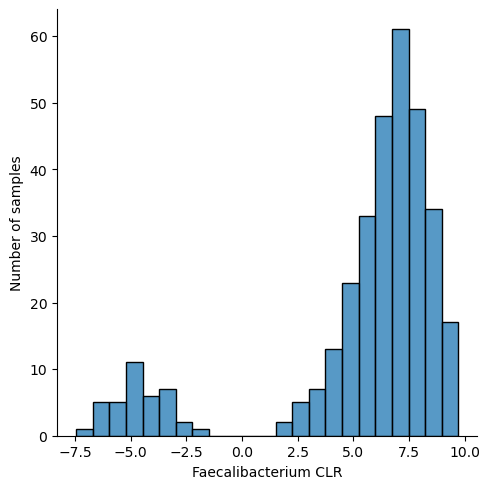

In [63]:
sns.displot(data=abund_clr,
            x='k__Bacteria;p__Firmicutes;c__Clostridia;o__Eubacteriales;f__Oscillospiraceae;g__Faecalibacterium')
plt.xlabel('Faecalibacterium CLR')
plt.ylabel('Number of samples')
plt.show()

Now, we have a bimodal distribution due to the presence of zeros. At this point, the most conservative option is to remove these values, because we cannot be sure if they are true zeros. 

In [66]:
# drop the samples that were zero (make NA so they will not be plotted)
abund_clr_nonzero = abund_clr[abund_nonzero]

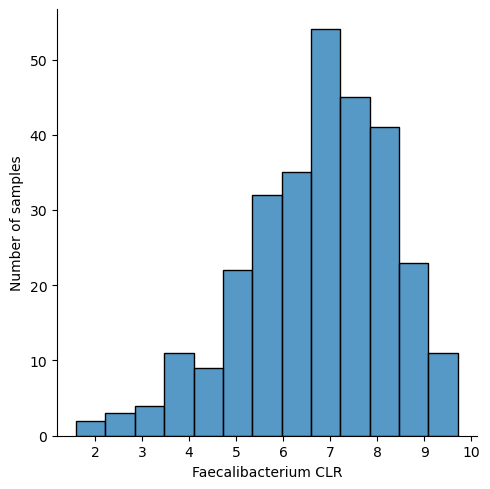

In [67]:
# now try plotting again
sns.displot(data=abund_clr_nonzero,
            x='k__Bacteria;p__Firmicutes;c__Clostridia;o__Eubacteriales;f__Oscillospiraceae;g__Faecalibacterium')
plt.xlabel('Faecalibacterium CLR')
plt.ylabel('Number of samples')
plt.show()

Now our data is _normal-ish_ (though still a bit skewed) but probably safe to use with parametric tests! This means we are ready to merge it back to the metadata.

In [68]:
merged_clr = complete_metadata.merge(abund_clr_nonzero, left_index=True, right_index=True)     # merge the two dataframes by their index (row names)
merged_clr

,parkinson_disease,sex,age,bmi,location,anticholinergic,antibiotics_bool,anti_inflammatory_bool,comt_inhibitor,carbidopa_levodopa,...,k__Bacteria;p__Firmicutes;c__Clostridia;o__Eubacteriales;f__Eubacteriales Family XIII. Incertae Sedis;g__Ihubacter,k__Bacteria;p__Proteobacteria;c__Deltaproteobacteria;o__Desulfovibrionales;f__Desulfovibrionaceae;g__Desulfovibrio,k__Bacteria;p__Proteobacteria;c__Epsilonproteobacteria;o__Campylobacterales;f__Campylobacteraceae;g__Campylobacter,k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Pasteurellales;f__Pasteurellaceae;g__Haemophilus,k__Bacteria;p__Firmicutes;c__Clostridia;o__Thermoanaerobacterales;f__Thermoanaerobacterales Family III. Incertae Sedis;g__Thermoanaerobacterium,k__Bacteria;p__Firmicutes;c__Erysipelotrichia;o__Erysipelotrichales;f__Erysipelotrichaceae;g__Longicatena,k__Bacteria;p__Firmicutes;c__Negativicutes;o__Veillonellales;f__Veillonellaceae;g__Veillonella,k__Bacteria;p__Firmicutes;c__Clostridia;o__Eubacteriales;f__Eubacteriales Family XIII. Incertae Sedis;g__Emergencia,k__Bacteria;p__Firmicutes;c__Clostridia;o__Eubacteriales;f__Lachnospiraceae;g__Tyzzerella,k__Bacteria;p__Firmicutes;c__Negativicutes;o__Acidaminococcales;f__Acidaminococcaceae;g__Acidaminococcus
id,,,,,,,,,,,,,,,,,,,,,
ERR1513669,No,female,79.0,28.34,"Atlanta, GA",N,No,Yes,N,N,...,NaN,NaN,NaN,NaN,6.219405,2.793750,NaN,4.498299,NaN,NaN
ERR1513670,No,female,70.0,33.12,"Atlanta, GA",N,No,Yes,N,N,...,2.579521,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.936077
ERR1513671,No,female,79.0,32.28,"Atlanta, GA",N,No,No,N,N,...,1.422718,NaN,NaN,NaN,2.962705,1.933310,NaN,NaN,NaN,NaN
ERR1513672,No,female,70.0,24.44,"Atlanta, GA",N,No,No,N,N,...,0.767784,NaN,1.278374,NaN,6.981804,1.055319,NaN,1.748245,NaN,NaN
ERR1513673,No,male,76.0,25.06,"Atlanta, GA",N,No,Yes,N,N,...,NaN,NaN,NaN,NaN,5.767822,NaN,NaN,NaN,5.516512,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ERR1514011,No,male,74.0,30.81,"Seattle, WA",N,No,No,N,N,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ERR1514012,No,female,66.0,41.96,"Seattle, WA",N,No,Yes,N,N,...,NaN,NaN,NaN,3.556826,3.046107,NaN,NaN,3.046107,NaN,NaN
ERR1514013,No,female,74.0,34.44,"Seattle, WA",N,No,Yes,N,N,...,1.814247,NaN,0.716369,NaN,NaN,2.101837,NaN,NaN,NaN,NaN


The code to perform a t-test is very similar to that of a Mann-Whitney U-test, but we need to also remove NAs.

We can accomplish this by adding `dropna()` to the end of our group assignment

In [71]:
# how we would do one t-test
faecali_clr_pd = merged_clr[merged_clr['parkinson_disease'] == 'Yes']['k__Bacteria;p__Firmicutes;c__Clostridia;o__Eubacteriales;f__Oscillospiraceae;g__Faecalibacterium'].dropna()
faecali_clr_hc = merged_clr[merged_clr['parkinson_disease'] == 'No']['k__Bacteria;p__Firmicutes;c__Clostridia;o__Eubacteriales;f__Oscillospiraceae;g__Faecalibacterium'].dropna()

t_stat, p_val = stats.ttest_ind(faecali_clr_pd, faecali_clr_hc, equal_var=False)

print(f"T-stat: {t_stat}")
print(f"p-value: {p_val}")

T-stat: -3.6285870905992974
p-value: 0.0003425401019522573


In people with _measurable_ amounts of Faecalibacterium, people with PD have significantly lower Faecalibacterium than people without. 

Notice how in trimming our data, we are now testing a different question.

### Multiple testing and FDR correction:

With this much interesting data, it would be pretty tedious to test variables one-by-one. This is why we made a list `genus_column` earlier.

In [73]:
# Create an empty list to store test results
t_test_results = []

# Loop through each genus column and perform the t-test
for genus in genus_columns:
    # Separate the data for Parkinson's disease 'Yes' and 'No' groups
    pd_group = merged_clr[merged_clr['parkinson_disease'] == 'Yes'][genus].dropna()
    hc_group = merged_clr[merged_clr['parkinson_disease'] == 'No'][genus].dropna()
    
    # Perform the t-test
    if len(pd_group) > 0 and len(hc_group) > 0:  # Only perform test if there are values in both groups
        t_stat, p_val = stats.ttest_ind(pd_group, hc_group, equal_var=False)
        
        # Store the results
        t_test_results.append({
            'genus': genus,
            't_stat': t_stat,
            'p_val': p_val,
            'n_pd': len(pd_group),
            'n_hc': len(hc_group)
        })

# Convert the results into a DataFrame
ttest_results_df = pd.DataFrame(t_test_results)

In [74]:
# take a look at our results dataframe
ttest_results_df

,genus,t_stat,p_val,n_pd,n_hc
0,k__Bacteria;__;__;__;__;__,-0.607438,0.544101,176,113
1,k__Bacteria;p__Firmicutes;c__Clostridia;o__Eub...,-1.833111,0.068612,118,83
2,k__Bacteria;p__Firmicutes;c__Clostridia;o__Eub...,-4.709539,0.000004,189,128
3,k__Bacteria;p__Firmicutes;c__Clostridia;o__Eub...,-3.628587,0.000343,173,119
4,k__Bacteria;p__Firmicutes;c__Clostridia;o__Eub...,-2.421118,0.016132,196,124
...,...,...,...,...,...
95,k__Bacteria;p__Firmicutes;c__Erysipelotrichia;...,0.390582,0.697999,60,25
96,k__Bacteria;p__Firmicutes;c__Negativicutes;o__...,0.497952,0.619749,53,38
97,k__Bacteria;p__Firmicutes;c__Clostridia;o__Eub...,0.593286,0.554399,79,43
98,k__Bacteria;p__Firmicutes;c__Clostridia;o__Eub...,0.405266,0.686369,66,39


What does our p-value distribution look like?

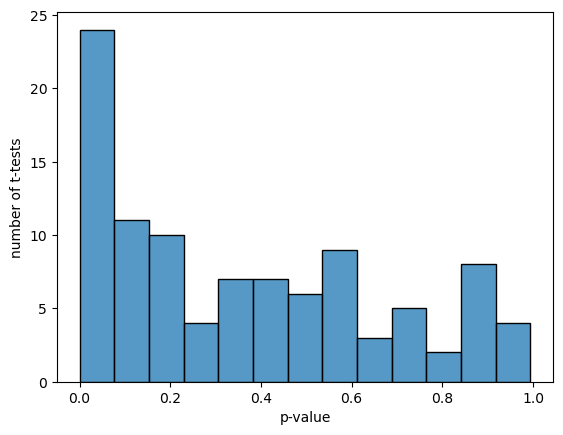

In [84]:
sns.histplot(data=ttest_results_df, x='p_val', bins=13)
plt.xlabel('p-value')
plt.ylabel('number of t-tests')
plt.show()

Looks ok? We expect a left skew given both true and false positives.

When we have a list of p-values, we can easily do FDR correction. We will use a Benjamini-Hochberg (BH) correction, which is less conservative than Bonferroni. The BH corrected p-value, q, is calculated as a function of the entire list of q-values.

In [75]:
from statsmodels.stats.multitest import multipletests

In [78]:
# do the FDR correction (this returns q-values in the order they were given)
qvals = multipletests(ttest_results_df['p_val'], method='fdr_bh')[1]

# append q-values to dataframe
ttest_results_df['q_val'] = qvals

# show the new dataframe, but sort by q-value
ttest_results_df.sort_values(by='q_val')

,genus,t_stat,p_val,n_pd,n_hc,q_val
33,k__Bacteria;p__Firmicutes;c__Clostridia;o__Eub...,-4.845231,0.000002,133,106,0.000117
35,k__Bacteria;p__Firmicutes;c__Clostridia;o__Eub...,-4.858808,0.000002,125,96,0.000117
2,k__Bacteria;p__Firmicutes;c__Clostridia;o__Eub...,-4.709539,0.000004,189,128,0.000132
25,k__Bacteria;p__Firmicutes;c__Clostridia;o__Eub...,-4.374117,0.000019,151,116,0.000468
7,k__Bacteria;p__Firmicutes;c__Clostridia;o__Eub...,-4.286936,0.000025,189,130,0.000510
...,...,...,...,...,...,...
56,k__Bacteria;p__Firmicutes;c__Clostridia;o__Eub...,-0.108314,0.913932,81,59,0.953956
75,k__Bacteria;p__Firmicutes;c__Tissierellia;o__T...,0.068585,0.945504,89,32,0.974746
28,k__Bacteria;p__Actinobacteria;c__Actinomycetia...,-0.035454,0.971861,79,28,0.991695
80,k__Bacteria;p__Firmicutes;c__Clostridia;o__Eub...,-0.006998,0.994425,104,75,0.994425


That's pretty cool! Let's separate just the significant hits

In [88]:
ttest_signif = ttest_results_df[ttest_results_df['q_val'] < 0.1]
ttest_signif

,genus,t_stat,p_val,n_pd,n_hc,q_val
2,k__Bacteria;p__Firmicutes;c__Clostridia;o__Eub...,-4.709539,0.000004,189,128,0.000132
3,k__Bacteria;p__Firmicutes;c__Clostridia;o__Eub...,-3.628587,0.000343,173,119,0.004282
7,k__Bacteria;p__Firmicutes;c__Clostridia;o__Eub...,-4.286936,0.000025,189,130,0.000510
9,k__Bacteria;p__Actinobacteria;c__Actinomycetia...,2.516550,0.012480,178,106,0.096004
25,k__Bacteria;p__Firmicutes;c__Clostridia;o__Eub...,-4.374117,0.000019,151,116,0.000468
33,k__Bacteria;p__Firmicutes;c__Clostridia;o__Eub...,-4.845231,0.000002,133,106,0.000117
35,k__Bacteria;p__Firmicutes;c__Clostridia;o__Eub...,-4.858808,0.000002,125,96,0.000117
38,k__Bacteria;p__Firmicutes;c__Clostridia;o__Eub...,-3.869231,0.000146,121,102,0.002090
40,k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o_...,-3.217599,0.001465,193,122,0.016279
46,k__Bacteria;p__Firmicutes;c__Clostridia;o__Eub...,-3.911859,0.000125,115,100,0.002080


In [97]:
ttest_signif['genus_plot'] = ttest_signif['genus'].str.split(';').apply(lambda x: ';'.join(x[-2:])) # take only the last 2 taxonomic levels
ttest_signif

,genus,t_stat,p_val,n_pd,n_hc,q_val,genus_plot
35,k__Bacteria;p__Firmicutes;c__Clostridia;o__Eub...,-4.858808,0.000002,125,96,0.000117,f__Lachnospiraceae;g__[Eubacterium]
33,k__Bacteria;p__Firmicutes;c__Clostridia;o__Eub...,-4.845231,0.000002,133,106,0.000117,f__Lachnospiraceae;g__Roseburia
2,k__Bacteria;p__Firmicutes;c__Clostridia;o__Eub...,-4.709539,0.000004,189,128,0.000132,f__Lachnospiraceae;__
25,k__Bacteria;p__Firmicutes;c__Clostridia;o__Eub...,-4.374117,0.000019,151,116,0.000468,f__Lachnospiraceae;g__Anaerobutyricum
7,k__Bacteria;p__Firmicutes;c__Clostridia;o__Eub...,-4.286936,0.000025,189,130,0.000510,f__Lachnospiraceae;g__Blautia
46,k__Bacteria;p__Firmicutes;c__Clostridia;o__Eub...,-3.911859,0.000125,115,100,0.002080,f__Eubacteriales;g__Lawsonibacter
38,k__Bacteria;p__Firmicutes;c__Clostridia;o__Eub...,-3.869231,0.000146,121,102,0.002090,f__Lachnospiraceae;g__Fusicatenibacter
3,k__Bacteria;p__Firmicutes;c__Clostridia;o__Eub...,-3.628587,0.000343,173,119,0.004282,f__Oscillospiraceae;g__Faecalibacterium
40,k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o_...,-3.217599,0.001465,193,122,0.016279,f__Bacteroidaceae;g__Phocaeicola
76,k__Bacteria;p__Firmicutes;c__Negativicutes;o__...,-3.124330,0.002096,133,88,0.020959,f__Acidaminococcaceae;g__Phascolarctobacterium


How can we visualize this information? Here, I've plotted the T-statistic for each significant hit, colored by q-value. 

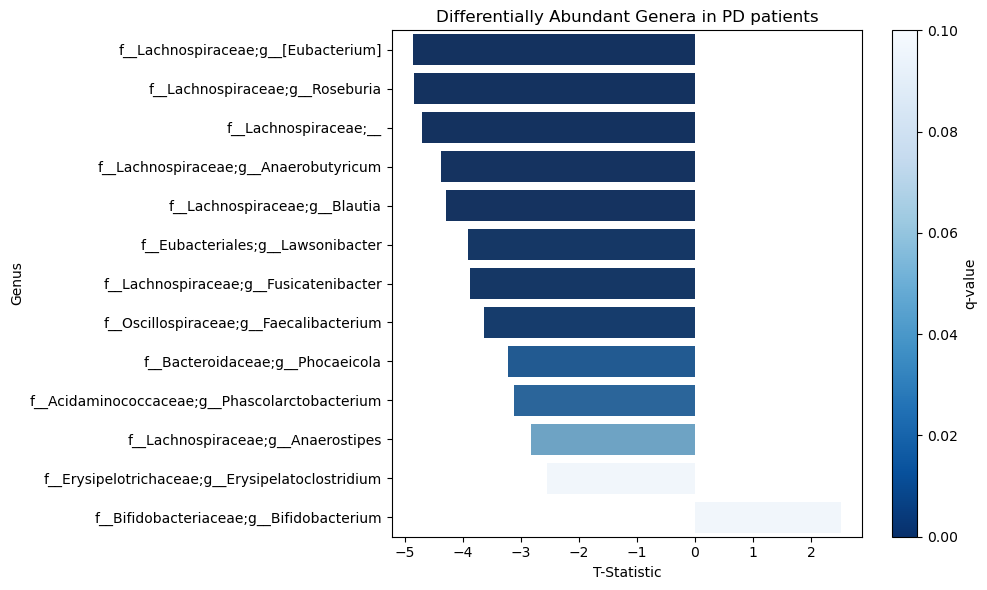

In [100]:
# Sort by absolute t-statistic for better visualization
ttest_signif = ttest_signif.sort_values(by='t_stat', key=abs, ascending=False)

# make a custom color palette that goes from light to dark based on the q-values
norm = plt.Normalize(0.0, 0.1)
cmap = plt.cm.Blues_r  # color map
bar_colors = cmap(norm(ttest_signif['q_val']))

# Plot
fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(data=ttest_signif, x='t_stat', y='genus_plot', palette=bar_colors, ax=ax)

# Make labels
ax.set_title('Differentially Abundant Genera in PD patients')
ax.set_xlabel('T-Statistic')
ax.set_ylabel('Genus')

# make a key for q-values
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)  # create ScalarMappable object
sm.set_array([])  # Empty array for ScalarMappable
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('q-value')

# Show the plot
plt.tight_layout()
plt.show()

---
# Exercise: Plant a Tree

One visualization that we did not spend a lot of time on was the phylogentic tree of our ASVs. Let's change that! We have seen that there are genera that appear in multiple populations in the previous step. But are the organisms in that genus actually the same?

Let's annotate the tree with our taxonomic classifications and abundances. We will use the empress plugin again but this time with the `community-plot` option. I filled in a template of the command for you. Can you figure out what has to go in the empty spaces?

**QUESTIONS:**

1) Are some of the branch lengths on the tree longer than you would expect? Do you notice anything interesting or suspicious about the taxonomic identities of these branches?

2) Can you find examples of phyla that are polyphyletic (i.e. where clusters of ASVs from the same phylum are found in different locations on the tree, showing different commmon ancestors)? What about polyphyletic taxa at lower taxonomic levels, like at the family or genus levels? Why do you think these patterns exist?

In [ ]:
# This won't run until you fill in the [EMPTY] spots with the right files ;)

!qiime empress community-plot \
    --i-tree [EMPTY] \
    --i-feature-table dada/table.qza \
    --m-sample-metadata-file [EMPTY] \
    --m-feature-metadata-file taxa.qza \
    --o-visualization community-tree-viz.qzv